# NBA Spatial Data

I obtained a dataset that tracks the location of the ball and each player on the court every 0.04 seconds in a game. It covers about 700 NBA games from Oct 2015 to Jan 2016. The size of the dataset is 60GB. 

In [1]:
import json, imp
import pandas as pd
import matplotlib.pyplot as plt
import bball, sqlite3
import seaborn as sns
import statsmodels.formula.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
#allow graphs to be shown in ipython notebook
%matplotlib inline

For each game, I caculated speed and acceleration at each moment when the game is going on, and I estimated the possession information across the whole game. I removed unreasonable observations.

In [4]:
db_filename = '/Volumes/lu/basketball.sqlite'
connection = sqlite3.connect(db_filename)
players = pd.read_sql('SELECT * FROM players', connection)
players = players.set_index('player_id')
downsample_spatial = pd.concat(pd.read_sql('SELECT * FROM downsampled_spatial_1_0', connection, chunksize=1000000),
                               ignore_index=True)
downsample_spatial.dropna(subset=['speed'], inplace=True)

## Smoothed speed of all players in one game:

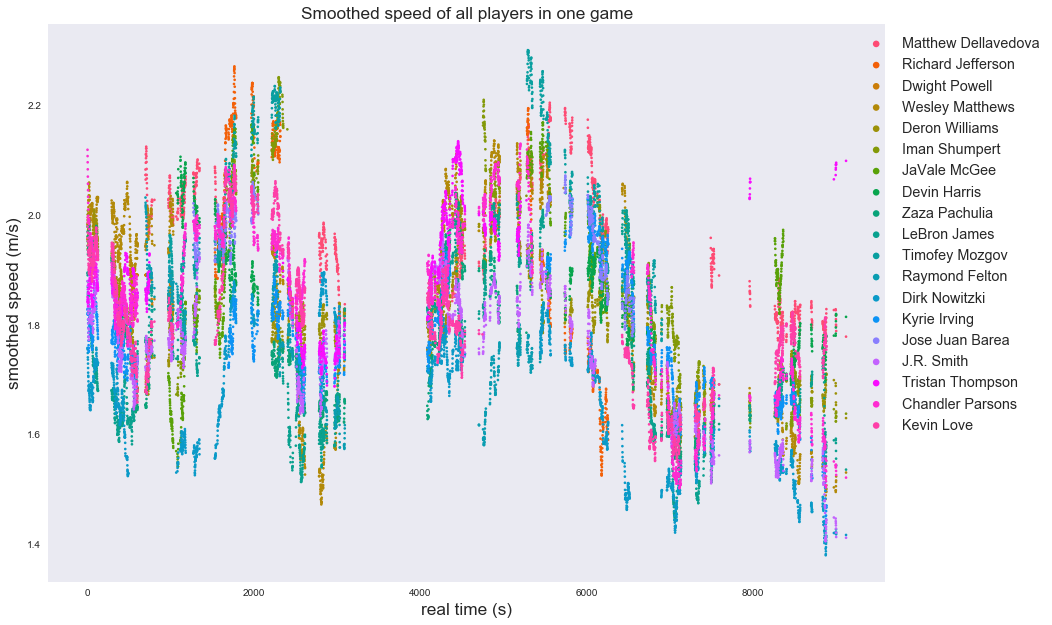

In [87]:
fig, ax = plt.subplots(figsize=(15, 10))
game = downsample_spatial[downsample_spatial['game_id'] == 21500575].copy()
game['real_time'] *= 1e-3
player_ids = set(game['player_id'])
colors = sns.husl_palette(n_colors=len(player_ids), s=1, l=0.6)
plt.autoscale(tight=True)
for i,player_id in enumerate(player_ids):   
    player_speed = game.loc[game['player_id'] == player_id,['real_time', 'speed']]
    rolling_player_speed = player_speed['speed'].rolling(window=300, center = True, min_periods=0).mean()
    player_speed['smoothed_speed'] = rolling_player_speed
    player_speed.plot(x ='real_time', y='smoothed_speed', color=colors[i], grid=False, edgecolors='none', 
                      kind='scatter', s=7, legend = False,  ax = ax)
ax.set_ylabel('smoothed speed (m/s)', fontdict={'fontsize': 'xx-large'})
ax.set_xlabel('real time (s)', fontdict={'fontsize': 'xx-large'})
ax.legend(players.loc[player_ids, 'name'],bbox_to_anchor=(1.2, 1.0),loc =1, fontsize='x-large', markerscale=2.5)
ax.set_title('Smoothed speed of all players in one game', fontsize='xx-large')

## Average speed of all players across 700 games (Smoothed and Linear regression)

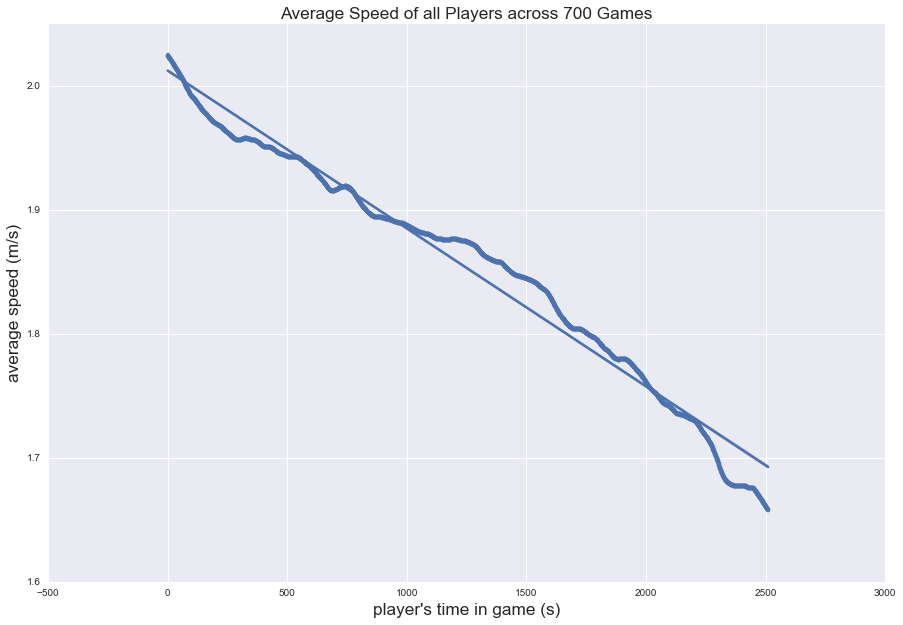

In [61]:
def smooth_plot(x, y, frac = 0.5, **kwargs):
    l = lowess(y, x, frac= frac)
    x = l[:,0]
    est_y = l[:,1]   
    return sns.regplot(x=x, y=est_y, **kwargs )

plt.figure(figsize=(15, 10))    
def speed_transform(downsampled_spatial, min_obs): 
    grouped_speeds = downsampled_spatial.groupby('time_in_game')
    speed = grouped_speeds['speed'].mean()
    valid_speed = grouped_speeds.size() > min_obs
    return speed[valid_speed].reset_index()
avg_speed = speed_transform(downsample_spatial, 100)
# plt.autoscale(tight=True)
ax = smooth_plot(avg_speed['time_in_game'],avg_speed['speed'], frac=0.05, truncate=True)
ax.set_xlabel("player's time in game (s)", fontdict={'fontsize': 'xx-large'})
ax.set_ylabel('average speed (m/s)', fontdict={'fontsize': 'xx-large'})
ax.set_title('Average Speed of all Players across 700 Games', fontsize='xx-large')

## Speed distribution of all players across 700 games

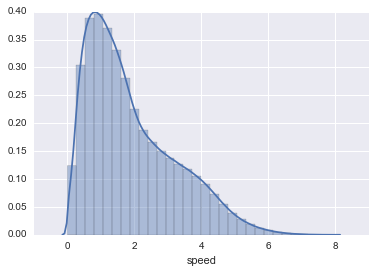

In [11]:
sns.distplot(downsample_spatial['speed'], bins=30)

In [58]:
def plot_player_spatial(player_id, connection, game_id=None, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    player_id = int(player_id.iloc[0])
    if game_id is None:
        player_spatial = pd.concat(pd.read_sql('SELECT * FROM spatial WHERE player_id=? AND speed NOT NULL', 
                                              params= [player_id], con=connection, chunksize=1000000), ignore_index=True)
    else:
        player_spatial = pd.read_sql('SELECT * FROM spatial WHERE player_id=? AND game_id=? AND speed NOT NULL', 
                                    params= [player_id, game_id], con=connection)

    first_half = player_spatial['cum_game_time'] < 1440
    second_half = ~first_half 
    rectangle_left = ((player_spatial['x']-5.25).abs()<30) & ((player_spatial['y']-25).abs()<10)
    rectangle_right = ((player_spatial['x']-88.75).abs()<30) & ((player_spatial['y']-25).abs()<10)
    for game_id in set(player_spatial['game_id']):
        game = (player_spatial['game_id'] == game_id)
        # defense should be always on the left side
        if (rectangle_left&first_half&game).sum() > (rectangle_right&first_half&game).sum():
            flip_side = second_half
        else:        
            flip_side = first_half
        player_spatial.loc[flip_side&game, 'x'] = 94 - player_spatial.loc[flip_side&game, 'x']
        player_spatial.loc[flip_side&game, 'y'] = 50 - player_spatial.loc[flip_side&game, 'y']
    
    
    colormap = sns.cubehelix_palette(as_cmap=True, rot=-0.5, start=0.15, dark=0, light=1,reverse=False)
    plt.hexbin(x=player_spatial['x'], y=player_spatial['y'], gridsize=40, cmap=colormap, axes=ax)
    #plt.colorbar()
    court = plt.imread('fullcourt.png')
    ax.imshow(court, zorder=1, extent=[0,94, 50, 0])
    ax.set_xlim([-10,104])
    ax.set_ylim([60,-10])
    ax.grid(False)

## Position Heat Map (Defense on the left)

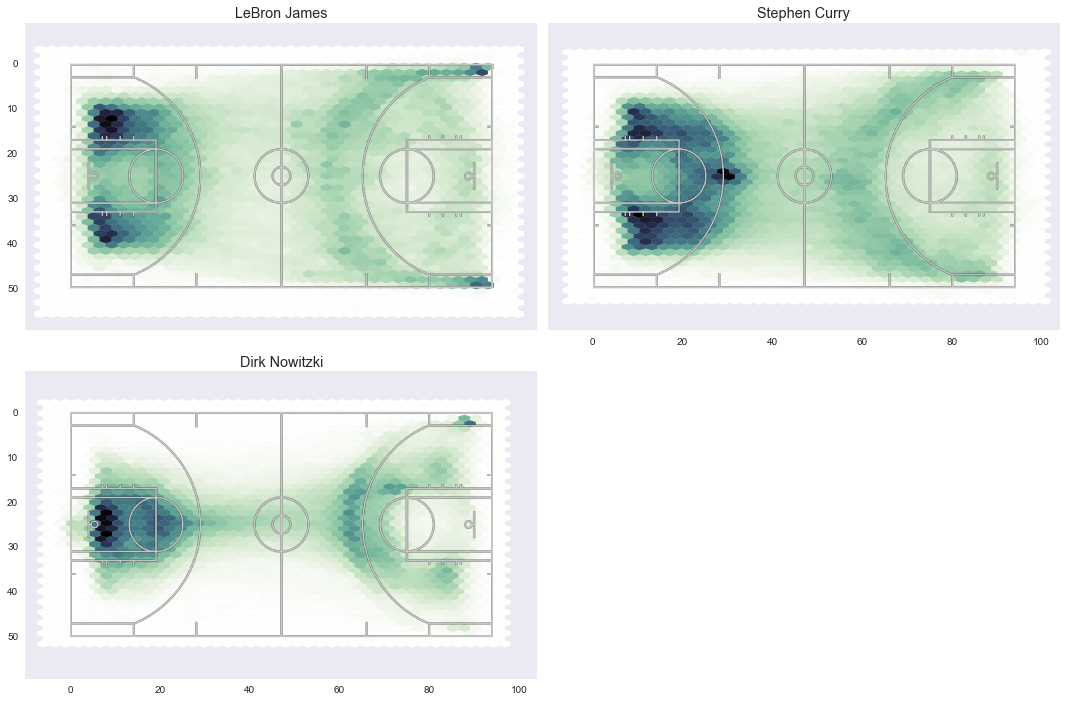

In [59]:
player_ids = [2544, 201939, 1717]
g = sns.FacetGrid(players.loc[player_ids].reset_index(), col='name', aspect=1.5, col_wrap=2, size=5)
g.map(plot_player_spatial,
      'player_id', 
      connection=connection)
g.set_titles("{col_name}", size='xx-large')
g.set_xlabels('')

In [101]:
def plot_player_avg_speed(player_id, downsample_spatial):
    fig, ax = plt.subplots(figsize=(15, 10))
    curry = downsample_spatial[downsample_spatial['player_id'] == player_id]
    groups = curry.groupby('time_in_game')
    curry_avg = groups['speed'].mean()
    curry_avg.name = 'average speed'
    speed_ax = curry_avg.plot(legend=True)
    num = groups.size()
    num.name = 'number of games'
    num_ax = num.plot(secondary_y=True, legend=True)
    num_ax.set_ylabel('number of games', fontdict={'fontsize': 'xx-large'})
    speed_ax.grid(False)
    speed_ax.set_title('Average Speed of Steph Curry over Games', fontsize='xx-large')
    speed_ax.set_ylabel('speed (m/s)', fontdict={'fontsize': 'xx-large'})
    speed_ax.set_xlabel('time in game (s)', fontdict={'fontsize': 'xx-large'})

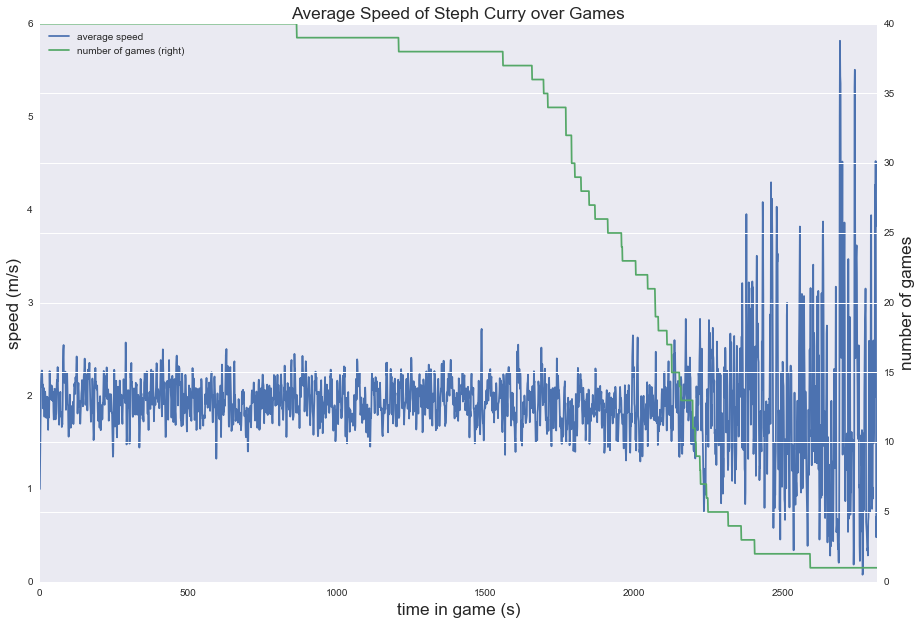

In [102]:
plot_player_avg_speed(201939, downsample_spatial)